In [1]:
from tdc.multi_pred import TCREpitopeBinding
from scripts.data_loader import DataDownloader

import seaborn as sns
import matplotlib.pyplot as plt

### **Getting to Know Our Data**  

In [2]:
downloader = DataDownloader()
data, df = downloader.fetch_weber_dataset()

Downloading...


Removing existing data directory: /home/gentroyal/outreachy-contributions/data


100%|██████████████████| 16.0M/16.0M [00:16<00:00, 944kiB/s]
Loading...
Done!


Dataset successfully downloaded to /home/gentroyal/outreachy-contributions/data
DataFrame shape: (47182, 5)


In [3]:
df.head()

,epitope_aa,epitope_smi,tcr,tcr_full,label
0,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSVWGTGKTYEQYF,SAVISQKPSRDICQRGTSLTIQCQVDSQVTMMFWYRQQPGQSLTLI...,1
1,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSVWGEGRSYEQYF,SAVISQKPSRDICQRGTSLTIQCQVDSQVTMMFWYRQQPGQSLTLI...,1
2,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSATILAGVPYGEQYF,GAVVSQHPSWVICKSGTSVKIECRSLDFQATTMFWYRQFPKQSLML...,1
3,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSASEGTSSYEQYF,GAVVSQHPSWVICKSGTSVKIECRSLDFQATTMFWYRQFPKQSLML...,1
4,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CASSFDREVTGELFF,GAGVSQTPSNKVTEKGKYVELRCDPISGHTALYWYRQSLGQGPEFL...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47182 entries, 0 to 47189
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   epitope_aa   47182 non-null  object
 1   epitope_smi  47182 non-null  object
 2   tcr          47182 non-null  object
 3   tcr_full     47182 non-null  object
 4   label        47182 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


#### Some Useful Methods  

Some methods gotten from running `help(data)`, the`data` documentation that may be useful later:  
- **`get_label_meaning()`** – get the biomedical meaning of label.
- **`print_stats()`** to print the statistics of the dataset
- **`label_distribution()`** - visualize distribution of labels

This will be updated as needed

In [5]:
data.print_stats() #Exploring print_stats()

--- Dataset Statistics ---
47182 data points.
--------------------------


In [6]:
df.label.value_counts()

label
1    23595
0    23587
Name: count, dtype: int64

#### **Brief EDA** 

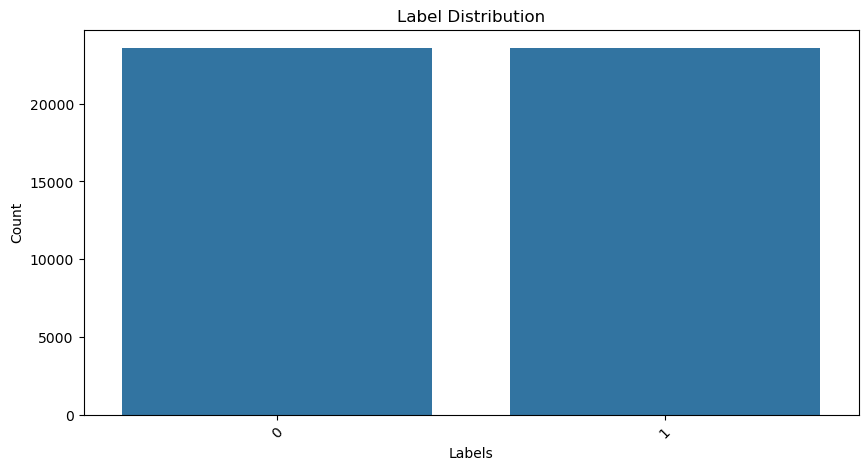

In [7]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df.label.value_counts().index, y=df.label.value_counts().values)

plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show();

**Comment:** There are 23595 of label 1 and 23587 of label 0. Since both classes have almost the same number of samples, it means that there is no imbalance. 
This implies that we can train our machine learning model without adjusting for class imbalance.

In [8]:
# Exploring `epitope_aa` column
unique_chars = set(''.join(df['epitope_aa'].astype(str).unique()))
amino_acids = set("ARNDCEQGHILKMFPSTWYV") # Known amino acids

is_amino_acid = unique_chars.issubset(amino_acids)

print("Unique characters in 'epitope_aa':", unique_chars)

# If all unique characters in `epitope_aa` are in the amino acids characters, then `epitope_aa` indeed represents amino acids
print("Contains only amino acids:", is_amino_acid) 

Unique characters in 'epitope_aa': {'Y', 'M', 'H', 'A', 'D', 'E', 'P', 'F', 'T', 'L', 'G', 'I', 'N', 'C', 'K', 'W', 'Q', 'V', 'S', 'R'}
Contains only amino acids: True


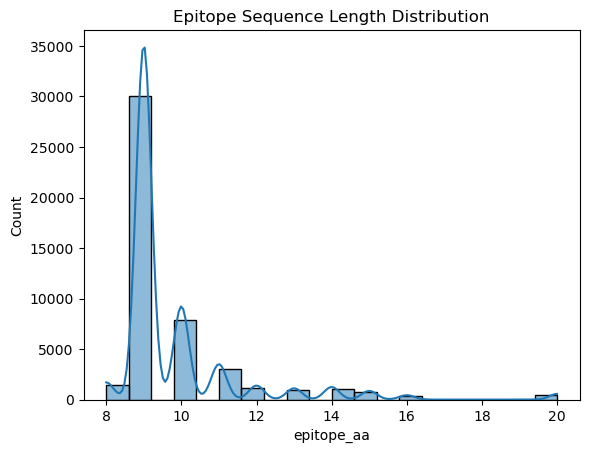

In [9]:
epitope_length = df['epitope_aa'].str.len()
sns.histplot(epitope_length, bins=20, kde=True)
plt.title("Epitope Sequence Length Distribution")
plt.show()

**Comment:** From this histogram, we see that most epitope sequences are around length of 9

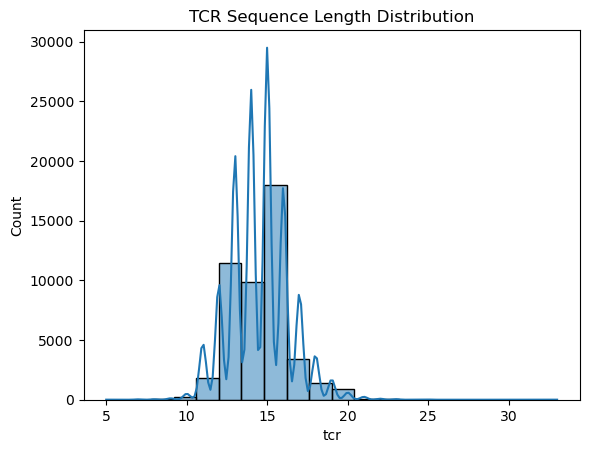

In [10]:
tcr_length = df['tcr'].str.len()
sns.histplot(tcr_length, bins=20, kde=True)
plt.title("TCR Sequence Length Distribution")
plt.show()

**Comment:** Here, we see that most TCR sequences have there lengths to be between 12 and 18, and we see some peaks around 12 and 14. 
We also see that there are rare occurrences of very short or very long sequences

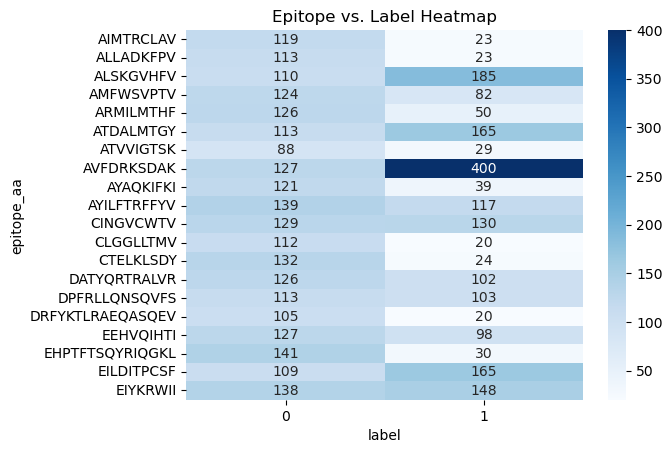

In [11]:
pivot_table = df.pivot_table(index='epitope_aa', columns='label', aggfunc='size', fill_value=0).head(20)
sns.heatmap(pivot_table, cmap="Blues", annot=True, fmt="d")
plt.title("Epitope vs. Label Heatmap")
plt.show()

**Comment:** This dataset has some null entries

**Comment:** For the first 20 epitones, we see that the heatmap shows how different sequences are linked to labels 0 and 1.
Some sequences appear more often with label 1, like "AVFDRKSD" with 400 in label 1 and 127 in label 0
Others like "EIYKRWII" (138 vs. 148) are more balanced between both labels.

### **Featurizer**  